In [1]:
import torch
from fastai.text.all import *

%matplotlib inline

In [2]:
dataset_path = untar_data(URLs.IMDB)
dataset_path.ls()

(#7) [Path('/home/ubuntu/.fastai/data/imdb/unsup'),Path('/home/ubuntu/.fastai/data/imdb/test'),Path('/home/ubuntu/.fastai/data/imdb/README'),Path('/home/ubuntu/.fastai/data/imdb/tmp_lm'),Path('/home/ubuntu/.fastai/data/imdb/tmp_clas'),Path('/home/ubuntu/.fastai/data/imdb/imdb.vocab'),Path('/home/ubuntu/.fastai/data/imdb/train')]

In [3]:
BROKEN_POS_FILE = dataset_path/'train/pos/1175_9.txt' #sample that breaks training (for unknown reason, might be because it's the larger file)

tok_rules = [
    lowercase,
    fix_html,
    spec_add_spaces,
    rm_useless_spaces,
]
x_tfms = [
    Tokenizer.from_folder(dataset_path, tok=TokenizeWithRules(WordTokenizer(), tok_rules), rules=[]),
    Numericalize()
]
y_tfms = [
    parent_label,
    Categorize()
]


dataset_files = get_text_files(dataset_path, folders=['train'])
dataset_files.remove(BROKEN_POS_FILE)

splitter = TrainTestSplitter(test_size=0.2, random_state=42)(dataset_files)
print("Train set size:", len(splitter[0]), "Val set size:", len(splitter[1]))

dsets = Datasets(dataset_files, [x_tfms, y_tfms], splits=splitter)

Train set size: 19999 Val set size: 5000


In [4]:
bs = 256
dloaders = dsets.dataloaders(dl_type=SortedDL, bs=bs, val_bs=bs, before_batch=pad_input, drop_last=True, val_drop_last=True, verbose=True)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: Pad_Input
Setting up after_batch: Pipeline: 


In [5]:
opt_func = partial(Adam, wd=0.1)
learner = text_classifier_learner(
    dloaders,
    AWD_LSTM,
    metrics=[accuracy],
    drop_mult=0.5,
    opt_func=opt_func
)
learner = learner.to_fp16()
learner.model = learner.model.to('cuda')

SuggestedLRs(valley=0.009120108559727669)

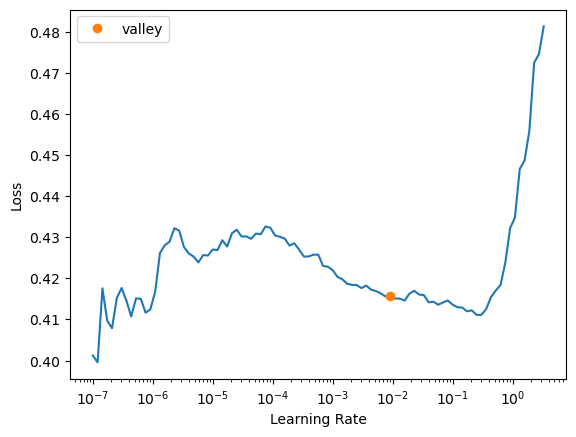

In [12]:
learner.lr_find()

In [13]:
learner.fit_one_cycle(10, 0.009, moms=(0.8, 0.7, 0.8))

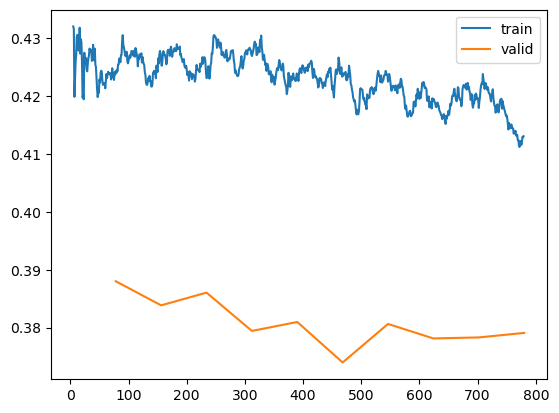

In [11]:
learner.recorder.plot_loss()